#### Objective
In this notebook, we are going to use the xgboost module to build a classifier on the newly generated features. As a comparison, we will use other classifiers such as logistic regression, KNN to do the same thing. We will see great performance improvements on the test set.

In [1]:
import pandas as pd
import numpy as np
import random
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss,accuracy_score
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from time import time
import seaborn as sns

In [2]:
# set the random seed
seed = 1234
np.random.seed(seed)
random.seed(seed)

In [3]:
train = pd.read_csv('new_features/new_features_add_precision_train_k43.csv')
test = pd.read_csv('new_features/new_features_add_precision_test_k43.csv')
X = np.array(train[['ice_prob','gmean','gmedian','gcount','KNN_prob']])
y = np.array(train['is_iceberg'])
test_X = np.array(test[['ice_prob','gmean','gmedian','gcount','KNN_prob']])
print('the shape of training set is',X.shape)
print('the shape of test set is',test_X.shape)

the shape of training set is (1471, 5)
the shape of test set is (8424, 5)


In [ ]:
def evaluate_model_logistic(title = 'Logistic Regression',K = 5,c_range = np.arange(0.1,20,0.1)):
    t0 = time()
    skf = StratifiedKFold(n_splits = K,random_state = 0)
    score_ls = []
    loss_ls = []
    for c in c_range:
        score = 0
        loss = 0
        clf = LogisticRegression(C = c)
        for train_index,test_index in skf.split(X,y):
            X_train,X_test = X[train_index],X[test_index]
            y_train,y_test = y[train_index],y[test_index]
            clf.fit(X_train,y_train)
            pred = clf.predict_proba(X_test)[:,1]
            score = score + accuracy_score(y_test,pred>0.5)
            loss = loss + log_loss(y_test,pred)
        score = score/K
        loss = loss/K
        score_ls.append(score)
        loss_ls.append(loss)
    fig = plt.figure(figsize = (12,6))
    fig.add_subplot(121)
    plt.plot(np.array(c_range),np.array(score_ls))
    plt.xlabel('value of c')
    plt.ylabel('accuracy')
    plt.title(title)
    fig.add_subplot(122)
    plt.plot(np.array(c_range),np.array(loss_ls))
    plt.xlabel('value of c')
    plt.ylabel('log_loss')
    plt.title(title)
    plt.show()
    print('the run time is',time() - t0)
    return np.array(loss_ls),c_range[np.argmin(np.array(loss_ls))]

d:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


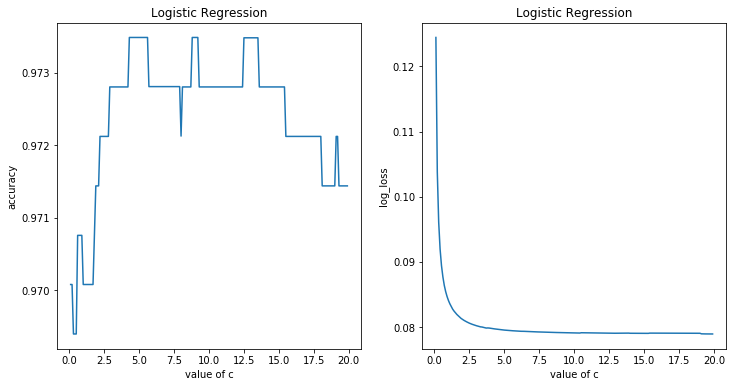

the run time is 3.3279130458831787
19.900000000000002


In [33]:
loss_ls,min_n = evaluate_model_logistic()
print(min_n)

### xgboost
We change the parameters of n_estimators and max_depth to control the bias-variance trade-off of the model.

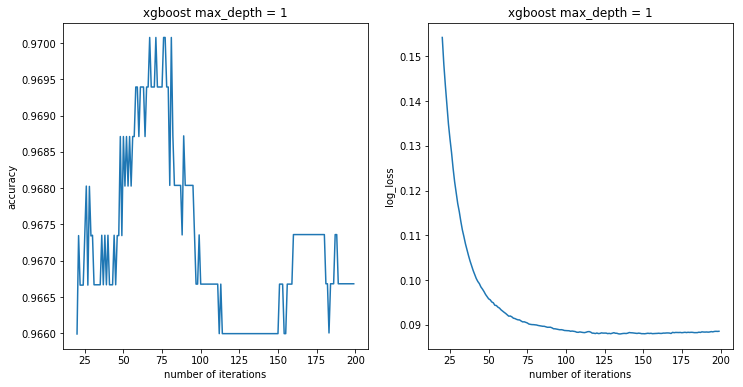

the run time is 31.761927604675293
minimum log_loss estimator is 135


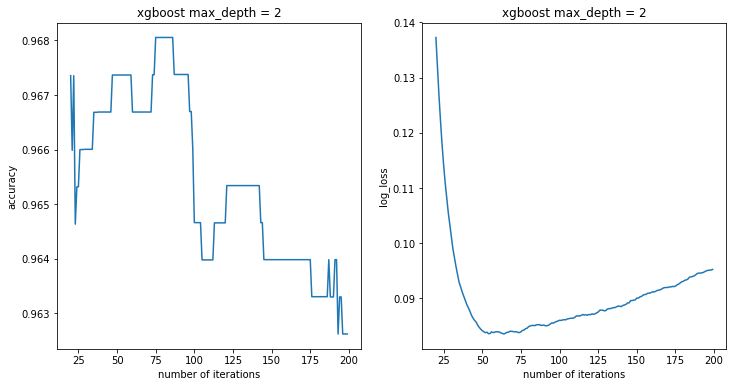

the run time is 46.21371579170227
minimum log_loss estimator is 64


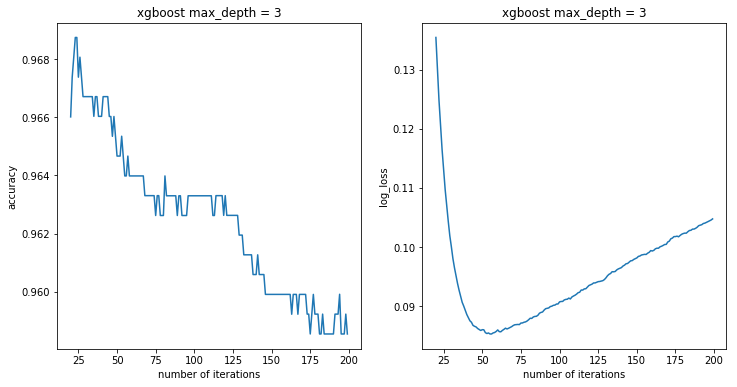

the run time is 58.314258098602295
minimum log_loss estimator is 56


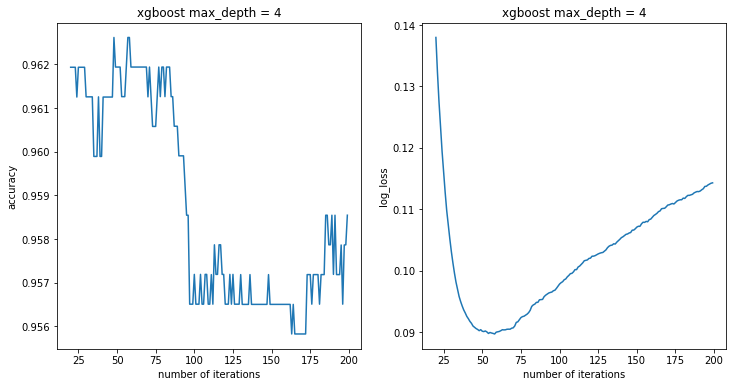

the run time is 70.7868971824646
minimum log_loss estimator is 58


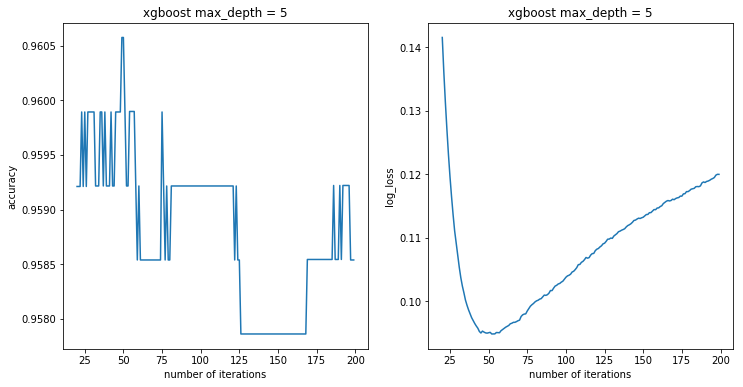

the run time is 78.14770412445068
minimum log_loss estimator is 52


In [21]:
def evaluate_model_xgboost(depth,K = 5,n_range = range(20,200)):
    title = title = 'xgboost max_depth = '+str(depth)
    t0 = time()
    skf = StratifiedKFold(n_splits = K,random_state = 0)
    score_ls = []
    loss_ls = []
    for n in n_range:
        score = 0
        loss = 0
        clf = xgb.XGBClassifier(n_estimators = n,max_depth = depth,gamma = 0)
        for train_index,test_index in skf.split(X,y):
            X_train,X_test = X[train_index],X[test_index]
            y_train,y_test = y[train_index],y[test_index]
            clf.fit(X_train,y_train)
            pred = clf.predict_proba(X_test)[:,1]
            score = score + accuracy_score(y_test,pred>0.5)
            loss = loss + log_loss(y_test,pred)
        score = score/K
        loss = loss/K
        score_ls.append(score)
        loss_ls.append(loss)
    fig = plt.figure(figsize = (12,6))
    fig.add_subplot(121)
    plt.plot(np.array(n_range),np.array(score_ls))
    plt.xlabel('number of iterations')
    plt.ylabel('accuracy')
    plt.title(title)
    fig.add_subplot(122)
    plt.plot(np.array(n_range),np.array(loss_ls))
    plt.xlabel('number of iterations')
    plt.ylabel('log_loss')
    plt.title(title)
    plt.show()
    print('the run time is',time() - t0)
    return np.array(loss_ls),n_range[np.argmin(np.array(loss_ls))]

for depth in np.arange(1,6):
    loss_ls,min_n = evaluate_model_xgboost(depth = depth)
    print('minimum log_loss estimator is',min_n)

xgboost provide a method to plot the importances of the features.

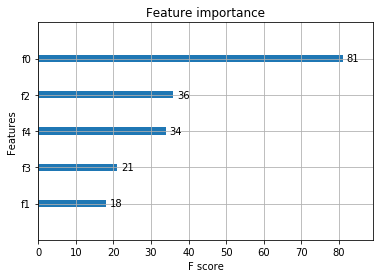

In [19]:
clf = xgb.XGBClassifier(n_estimators = 71,max_depth = 2,gamma = 0)
clf.fit(X,y)
pred = clf.predict_proba(test_X)[:,1]
xgb.plot_importance(clf)

### KNN model

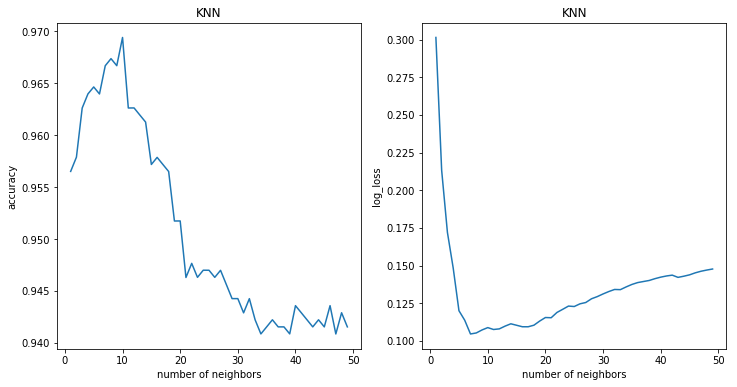

the run time is 1.5044994354248047
7


In [56]:
def evaluate_model_knn(title = 'KNN',K = 5,n_range = range(1,50)):
    t0 = time()
    skf = StratifiedKFold(n_splits = K,random_state = 0)
    score_ls = []
    loss_ls = []
    for n in n_range:
        score = 0
        loss = 0
        clf =  KNeighborsClassifier(n)
        for train_index,test_index in skf.split(X,y):
            X_train,X_test = X[train_index],X[test_index]
            y_train,y_test = y[train_index],y[test_index]
            clf.fit(X_train,y_train)
            pred = clf.predict_proba(X_test)[:,1]
            pred = np.clip(pred,0.001,0.999)
            score = score + accuracy_score(y_test,pred>0.5)
            loss = loss + log_loss(y_test,pred)
        score = score/K
        loss = loss/K
        score_ls.append(score)
        loss_ls.append(loss)
    fig = plt.figure(figsize = (12,6))
    fig.add_subplot(121)
    plt.plot(np.array(n_range),np.array(score_ls))
    plt.xlabel('number of neighbors')
    plt.ylabel('accuracy')
    plt.title(title)
    fig.add_subplot(122)
    plt.plot(np.array(n_range),np.array(loss_ls))
    plt.xlabel('number of neighbors')
    plt.ylabel('log_loss')
    plt.title(title)
    plt.show()
    print('the run time is',time() - t0)
    return np.array(loss_ls),n_range[np.argmin(np.array(loss_ls))]

loss_ls,min_n = evaluate_model_knn()
print(min_n)

### The correlation matrix of the probability features

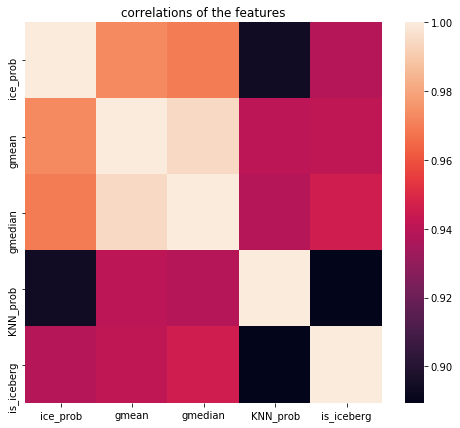

In [50]:
labels = ['ice_prob','gmean','gmedian','KNN_prob','is_iceberg']
corr = train[labels].corr()
fig = plt.figure(figsize = (8,7))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.title('correlations of the features')
plt.show()